# Ансамблевые модели (RandomForest, XGBoost)

---

## Импорт библиотек и загрузка данных

In [1]:
import time
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import seaborn as sns

In [2]:
df = pd.read_csv("./Task/LabML_5.1/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Подготовка данных

In [3]:
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (614, 8) Test shape: (154, 8)


---

## Задание 1 - Классификация методом случайного леса

In [4]:
rf_base = RandomForestClassifier(random_state=42)
t0 = time.time()
rf_base.fit(X_train, y_train)
train_time_base = time.time() - t0

y_pred_rf = rf_base.predict(X_test)

metrics_rf_base = {
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "Precision": precision_score(y_test, y_pred_rf, zero_division=0),
    "Recall": recall_score(y_test, y_pred_rf, zero_division=0),
    "F1": f1_score(y_test, y_pred_rf, zero_division=0),
    "Train_time_sec": train_time_base
}
metrics_rf_base

{'Accuracy': 0.7727272727272727,
 'Precision': 0.7111111111111111,
 'Recall': 0.5925925925925926,
 'F1': 0.6464646464646465,
 'Train_time_sec': 0.07805585861206055}

___

## Задание 2 - Исследование качества модели от глубины деревьев  
#### Фиксируем остальные параметры по умолчанию, перебираем max_depth и строим график F1 vs max_depth

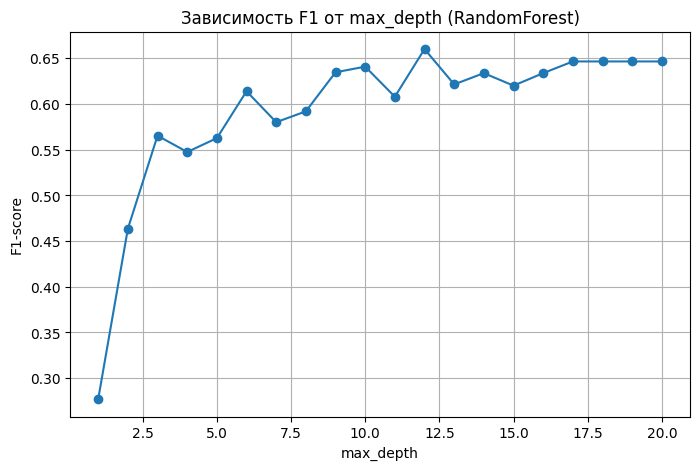

In [5]:
depths = list(range(1, 21))
f1_by_depth = []
time_by_depth = []

for d in depths:
    clf = RandomForestClassifier(max_depth=d, random_state=42)
    t0 = time.time()
    clf.fit(X_train, y_train)
    elapsed = time.time() - t0
    y_pred = clf.predict(X_test)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    f1_by_depth.append(f1)
    time_by_depth.append(elapsed)

plt.figure(figsize=(8,5))
plt.plot(depths, f1_by_depth, marker="o")
plt.xlabel("max_depth")
plt.ylabel("F1-score")
plt.title("Зависимость F1 от max_depth (RandomForest)")
plt.grid()
plt.show()

### Выводим лучшую глубину по `F1`

In [6]:
best_idx = int(np.argmax(f1_by_depth))
best_depth = depths[best_idx]
best_f1 = f1_by_depth[best_idx]
print(f"Best max_depth = {best_depth} with F1 = {best_f1:.4f}")

Best max_depth = 12 with F1 = 0.6600


---

## Задание 3 - Исследование качества модели от числа признаков, подаваемых на дерево `max_features`  
#### Перебираем разные варианты max_features и строим график

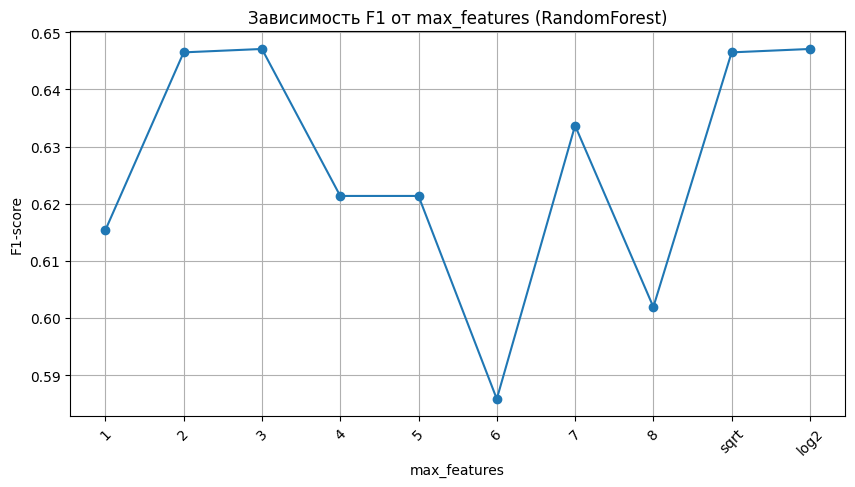

In [7]:
n_features = X.shape[1]
mf_values = list(range(1, n_features+1)) + ["sqrt", "log2"]
f1_by_mf = []
labels_mf = []

for mf in mf_values:
    clf = RandomForestClassifier(max_features=mf, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    f1_by_mf.append(f1)
    labels_mf.append(str(mf))

plt.figure(figsize=(10,5))
plt.plot(labels_mf, f1_by_mf, marker="o")
plt.xlabel("max_features")
plt.ylabel("F1-score")
plt.title("Зависимость F1 от max_features (RandomForest)")
plt.grid()
plt.xticks(rotation=45)
plt.show()

---

## Задание 4 - Исследование качества модели от числа деревьев + время  
#### Для ряда значений n_estimators считаем `F1` и время обучения, строим двойной график

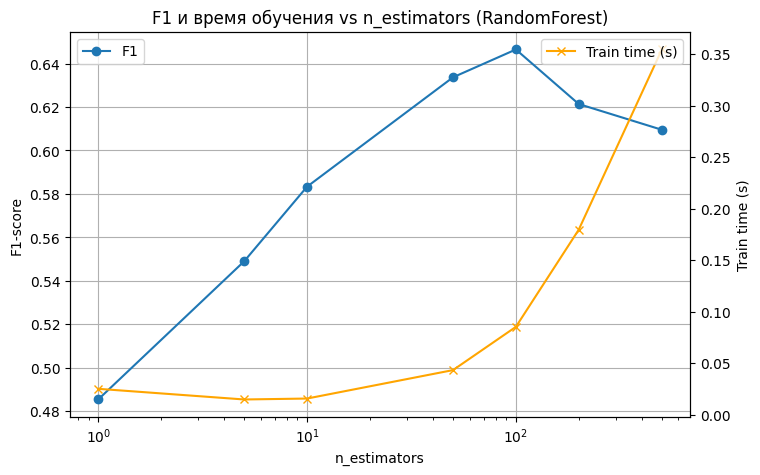

In [8]:
n_list = [1, 5, 10, 50, 100, 200, 500]
f1_by_n = []
time_by_n = []

for n in n_list:
    clf = RandomForestClassifier(n_estimators=n, random_state=42, n_jobs=-1)
    t0 = time.time()
    clf.fit(X_train, y_train)
    elapsed = time.time() - t0
    y_pred = clf.predict(X_test)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    f1_by_n.append(f1)
    time_by_n.append(elapsed)

fig, ax1 = plt.subplots(figsize=(8,5))
ax1.plot(n_list, f1_by_n, marker="o", label="F1")
ax1.set_xlabel("n_estimators")
ax1.set_xscale("log")
ax1.set_ylabel("F1-score")
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(n_list, time_by_n, marker="x", color="orange", label="Train time (s)")
ax2.set_ylabel("Train time (s)")

plt.title("F1 и время обучения vs n_estimators (RandomForest)")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.show()

---

## Задание 5

#### Классифицируем на XGBoost. Подбираем гиперпараметры, исследуем время и качество. Сравниваем с RandomForest.

In [9]:
param_sets = [
    {"n_estimators":50, "max_depth":3, "learning_rate":0.1, "subsample":1, "reg_alpha":0, "reg_lambda":1},
    {"n_estimators":100, "max_depth":3, "learning_rate":0.05, "subsample":0.8, "reg_alpha":0, "reg_lambda":1},
    {"n_estimators":100, "max_depth":5, "learning_rate":0.1, "subsample":0.8, "reg_alpha":1, "reg_lambda":1},
    {"n_estimators":200, "max_depth":4, "learning_rate":0.05, "subsample":0.7, "reg_alpha":0.5, "reg_lambda":1},
]

xgb_results = []
for params in param_sets:
    clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', **params)
    t0 = time.time()
    clf.fit(X_train, y_train)
    elapsed = time.time() - t0
    y_pred = clf.predict(X_test)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    acc = accuracy_score(y_test, y_pred)
    xgb_results.append({**params, "F1":f1, "Accuracy":acc, "Train_time_sec":elapsed})

# результаты в виде таблицы
pd.DataFrame(xgb_results)

/Users/a.sagitovich/programming/BFU/7 sem/Мищук - Основы ML/Lab5/.venv/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [10:52:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/a.sagitovich/programming/BFU/7 sem/Мищук - Основы ML/Lab5/.venv/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [10:52:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/a.sagitovich/programming/BFU/7 sem/Мищук - Основы ML/Lab5/.venv/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [10:52:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/a.sagitovich/programming/BFU/7 sem/Мищук - Основы ML/Lab5/.venv/li

,n_estimators,max_depth,learning_rate,subsample,reg_alpha,reg_lambda,F1,Accuracy,Train_time_sec
0,50,3,0.10,1.0,0.0,1,0.601942,0.733766,0.056835
1,100,3,0.05,0.8,0.0,1,0.615385,0.740260,0.073508
2,100,5,0.10,0.8,1.0,1,0.642202,0.746753,0.113561
3,200,4,0.05,0.7,0.5,1,0.635514,0.746753,0.211614


### Сравнение RandomForest

In [13]:
best_rf_idx = int(np.argmax(f1_by_n))  # из исследования по n_estimators
best_rf_n = n_list[best_rf_idx]

best_rf = RandomForestClassifier(n_estimators=best_rf_n, max_depth=best_depth, random_state=42, n_jobs=-1)
t0 = time.time()
best_rf.fit(X_train, y_train)
rf_train_time = time.time() - t0
y_pred_best_rf = best_rf.predict(X_test)
rf_f1 = f1_score(y_test, y_pred_best_rf, zero_division=0)
rf_acc = accuracy_score(y_test, y_pred_best_rf)

print("RandomForest (выбран): n_estimators =", best_rf_n, "max_depth =", best_depth)
print(f"RF: Accuracy = {rf_acc:.4f}, F1 = {rf_f1:.4f}, Train_time = {rf_train_time:.3f}s")

# выбрать лучший XGB из предыдущего списка
df_xgb_res = pd.DataFrame(xgb_results)
best_xgb_row = df_xgb_res.loc[df_xgb_res["F1"].idxmax()]
print("\nЛучший XGBoost:")
display(best_xgb_row)

RandomForest (выбран): n_estimators = 100 max_depth = 12
RF: Accuracy = 0.7792, F1 = 0.6600, Train_time = 0.097s

Лучший XGBoost:


n_estimators      100.000000
max_depth           5.000000
learning_rate       0.100000
subsample           0.800000
reg_alpha           1.000000
reg_lambda          1.000000
F1                  0.642202
Accuracy            0.746753
Train_time_sec      0.113561
Name: 2, dtype: float64